# UI Classification with MobileNetV3
In this notebook, you will train an image classification model using transfer learning on MobileNetV3 to classify UIs.

For the dataset, I do recomment to use the [Figma Dummy Gen](https://github.com/dusskapark/figma-dummy-gen) plugin to generate dummy data for your training.

### Install dependencies

> if you are using Apple silicon, please install the TensorFlow Metal plugin to enable GPU support ([Link](https://developer.apple.com/metal/tensorflow-plugin/))

In [39]:
import os
import numpy as np
from PIL import Image
import json
import datetime
import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflowjs as tfjs



# Define the root path and the origin path
root_path = os.path.expanduser('./dataset/')
origin_path = root_path + 'TF_Image_classification/'
ui_path = root_path + 'ui/'
screenshot_path = root_path + 'screenshot/'

### Resizing images 

The images in the dataset are resized to 224x224x3, which is the input size for MobileNetV3.

> Please refer to TensorFlow Hub for more information about MobileNetV3 ([Link](https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5))

#### Double check the origin dataset

The dataset is stored in the `origin_path`. The folder structure is as follows:

```
TF_Image_classification
|__ Accordion
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ App Bar
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
```

In [30]:

# Initialize an empty dictionary to store the folder names and the number of files in each folder
folders_files_count = {}

# Loop through each folder in the origin path
for folder_name in os.listdir(origin_path):
    # Construct the full path to the folder
    folder_path = os.path.join(origin_path, folder_name)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Get the list of files in the directory
        files_in_folder = os.listdir(folder_path)
        
        # Count the number of files and store it in the dictionary
        folders_files_count[folder_name] = len(files_in_folder)

# Sort the dictionary by the number of files in each folder in ascending order
sorted_folders_files_count = sorted(folders_files_count.items(), key=lambda item: item[1])

# Print the number of files in each folder
for folder_name, files_count in sorted_folders_files_count:
    print(f'|- {folder_name}/ ({files_count} files)')

|- Avatar/ (30 files)
|- Tile/ (32 files)
|- Snackbar/ (64 files)
|- Tooltip/ (72 files)
|- Thumbnail/ (80 files)
|- Slider/ (80 files)
|- Segmented Control/ (80 files)
|- Quick Actions/ (132 files)
|- Bottom navigation/ (136 files)
|- Modal loader/ (192 files)
|- Link/ (216 files)
|- Onboarding Stories/ (216 files)
|- App Bar/ (240 files)
|- Tag/ (256 files)
|- OTP/ (257 files)
|- Status/ (288 files)
|- Section Header/ (288 files)
|- Super carousel/ (288 files)
|- Accordion/ (320 files)
|- Quick Select/ (344 files)
|- Buttons/ (354 files)
|- Badge/ (368 files)
|- Dropdown/ (416 files)
|- Filter and sort/ (432 files)
|- Bottom sheet/ (512 files)
|- Progress Tracker/ (592 files)
|- Tab/ (672 files)
|- Selection controls/ (935 files)
|- Enter amount/ (1152 files)
|- Card/ (1169 files)
|- Banner/ (1536 files)
|- Nudge/ (2048 files)
|- Super header/ (2304 files)
|- Text Field/ (2560 files)
|- Icon/ (3419 files)
|- List items/ (5232 files)


#### Resize images to fit for MobileNetV3 and split the dataset

The resized images will be stored in the `ui_path`. The folder structure is as follows:

In [43]:
# Define the target size
target_size = 224

# Create the new directory if it doesn't exist
os.makedirs(ui_path, exist_ok=True)

# Get the list of all folders in the origin and screenshot paths
all_folders = set(os.listdir(origin_path) + os.listdir(screenshot_path))

# Loop through each folder in the list
for folder_name in all_folders:
    # Construct the full path to the origin and screenshot folders
    origin_folder_path = os.path.join(origin_path, folder_name)
    screenshot_folder_path = os.path.join(screenshot_path, folder_name)

    # Check if the origin and screenshot folders exist
    origin_exists = os.path.isdir(origin_folder_path)
    screenshot_exists = os.path.isdir(screenshot_folder_path)

    # If neither folder exists, skip this folder
    if not origin_exists and not screenshot_exists:
        print(f"Folder {folder_name} does not exist in either the origin or screenshot path. Please check the data.")
        continue

    # Get the list of files in the origin and screenshot folders
    origin_files = os.listdir(origin_folder_path) if origin_exists else []
    screenshot_files = os.listdir(screenshot_folder_path) if screenshot_exists else []

    # If the number of screenshot files is less than or equal to 200
    if len(screenshot_files) <= 200:
        # Calculate the number of files to select from the origin folder
        num_files_to_select = min(len(origin_files), 200-len(screenshot_files))

        # Randomly select files from the origin folder
        selected_origin_files = np.random.choice(origin_files, size=num_files_to_select, replace=False).tolist() if num_files_to_select > 0 else []
    else:
        print(f"Folder {folder_name} has more than 200 images. Please check the data.")
        continue

    # Combine the screenshot and selected origin files
    combined_files = screenshot_files + selected_origin_files

    # Shuffle the combined files
    np.random.shuffle(combined_files)

    # Create the new folder if it doesn't exist
    new_folder_path = os.path.join(ui_path, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Loop through each file in the combined files
    for filename in combined_files:
        # Only process .png files
        if filename.endswith('.png'):
            # Check if the file is from the screenshot or origin folder
            if filename in screenshot_files:
                folder_path = screenshot_folder_path
            else:
                folder_path = origin_folder_path

            # Construct the full path to the file
            file_path = os.path.join(folder_path, filename)
            
            # Open the image file
            img = Image.open(file_path).convert("RGBA")
            
            # Get the width and height of the image
            width, height = img.size
            
            # Create a new square image with alpha channel
            new_image = Image.new('RGBA', (max(width, height), max(width, height)))
            
            # Paste the original image into the center of the new image
            new_image.paste(img, (int((new_image.width - img.width) / 2), int((new_image.height - img.height) / 2)))
            
            # Create a white background image
            bg = Image.new('RGBA', new_image.size, (255, 255, 255, 255))  # RGBA mode
            
            # Combine the new image with the white background
            final_image = Image.alpha_composite(bg, new_image)
            
            # Resize the final image to the target size
            final_image = final_image.resize((target_size, target_size), Image.LANCZOS)
            
            # Construct the new file path
            new_file_path = os.path.join(new_folder_path, filename)
            
            # Save the new image as PNG
            final_image.save(new_file_path, format='PNG')
            
            # Print the result
            print(f"Saved new image at {new_file_path}")

Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 154.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 29.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 67.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 75.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 147.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 108.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 16.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 85.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 161.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 226.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 56.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 216.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 163.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 138.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 77.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 207.png
Saved new image at ./dataset/ui/Tag/Tag _ v1.0 - 40.png
Saved new image at ./dataset/ui/Tag/Tag

We need to turn this dataset into a Tensorflow Dataset format. Fortunately, Tensorflow provides the ImageFolder dataset structure which is compatible with the format we downloaded the data in. 

We will then use the builder to build the raw versions of our train, test, and validation data.

In [44]:
# Function to get the number of files in a directory
def get_num_files(path):
    return len([entry for entry in os.scandir(path) if entry.is_file()])

# Function to print the directory tree
def draw_folder_tree(path, level=0):
    expanded_path = os.path.expanduser(path)
    folders_files_count = {}

    for entry in os.scandir(expanded_path):
        if entry.is_dir():
            num_files = get_num_files(entry.path)
            folders_files_count[entry.name] = num_files

    sorted_folders_files_count = sorted(folders_files_count.items(), key=lambda item: item[1])

    for folder_name, files_count in sorted_folders_files_count:
        print(f"{'    '*level}|- {folder_name}/ ({files_count} files)")
        draw_folder_tree(os.path.join(path, folder_name), level+1)


# Draw the folder tree of the new directory
print('Train structure:')
draw_folder_tree(ui_path)

Train structure:
|- Tile/ (32 files)
|- Avatar/ (58 files)
|- Thumbnail/ (80 files)
|- Slider/ (80 files)
|- Segmented Control/ (80 files)
|- Tooltip/ (90 files)
|- Snackbar/ (121 files)
|- Quick Actions/ (132 files)
|- Bottom navigation/ (136 files)
|- Icon/ (197 files)
|- OTP/ (199 files)
|- Selection controls/ (199 files)
|- Super header/ (200 files)
|- Quick Select/ (200 files)
|- Dropdown/ (200 files)
|- Card/ (200 files)
|- Buttons/ (200 files)
|- List items/ (200 files)
|- Accordion/ (200 files)
|- Modal loader/ (200 files)
|- Status/ (200 files)
|- Tab/ (200 files)
|- Nudge/ (200 files)
|- Enter amount/ (200 files)
|- Bottom sheet/ (200 files)
|- Section Header/ (200 files)
|- Link/ (200 files)
|- Onboarding Stories/ (200 files)
|- Filter and sort/ (200 files)
|- App Bar/ (200 files)
|- Text Field/ (200 files)
|- Tag/ (200 files)
|- Super carousel/ (200 files)
|- Banner/ (200 files)
|- Progress Tracker/ (200 files)
|- Badge/ (200 files)


### Train the model

We will use the MobileNetV3 model from TensorFlow Hub to train our model. 
We also use data augmentation to improve the model's accuracy as well as prevent overfitting.

In [71]:
# Define the parameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.2
split_ratio = [0.7, 0.2, 0.1]

# Create a data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Load the images from the directory
train_data = datagen.flow_from_directory(
    ui_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_data = datagen.flow_from_directory(
    ui_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

# Load the MobileNetV2 model from TensorFlow Hub
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenet = hub.KerasLayer(model_url, trainable=True)

# Create a new model
model = tf.keras.models.Sequential([
    mobilenet,
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with the augmented data
history = model.fit(
    train_data,
    epochs=30,
    validation_data=validation_data,
    callbacks=[early_stopping]
)

Found 4347 images belonging to 36 classes.
Found 1857 images belonging to 36 classes.
Epoch 1/30
136/136 [==============================] - 318s 2s/step - loss: 1.6023 - categorical_accuracy: 0.6285 - val_loss: 1.3299 - val_categorical_accuracy: 0.7087
Epoch 2/30
136/136 [==============================] - 274s 2s/step - loss: 0.4496 - categorical_accuracy: 0.9156 - val_loss: 0.8222 - val_categorical_accuracy: 0.8411
Epoch 3/30
136/136 [==============================] - 258s 2s/step - loss: 0.2818 - categorical_accuracy: 0.9522 - val_loss: 0.7071 - val_categorical_accuracy: 0.8724
Epoch 4/30
136/136 [==============================] - 290s 2s/step - loss: 0.2169 - categorical_accuracy: 0.9657 - val_loss: 0.7074 - val_categorical_accuracy: 0.8794
Epoch 5/30
136/136 [==============================] - 307s 2s/step - loss: 0.1859 - categorical_accuracy: 0.9740 - val_loss: 0.8096 - val_categorical_accuracy: 0.8745
Epoch 6/30
136/136 [==============================] - 264s 2s/step - loss: 0.17

In [72]:
history.history

# model.summary()

{'loss': [1.602329969406128,
  0.44955897331237793,
  0.2817939519882202,
  0.21693363785743713,
  0.18587614595890045,
  0.17421495914459229],
 'categorical_accuracy': [0.6284794211387634,
  0.9155739545822144,
  0.9521508812904358,
  0.9657235145568848,
  0.9740050435066223,
  0.9765355587005615],
 'val_loss': [1.3299065828323364,
  0.8222211003303528,
  0.7070831060409546,
  0.7073794007301331,
  0.8095983862876892,
  0.7528175711631775],
 'val_categorical_accuracy': [0.708669900894165,
  0.8411416411399841,
  0.8723747730255127,
  0.8793753385543823,
  0.8745288252830505,
  0.8691437840461731]}

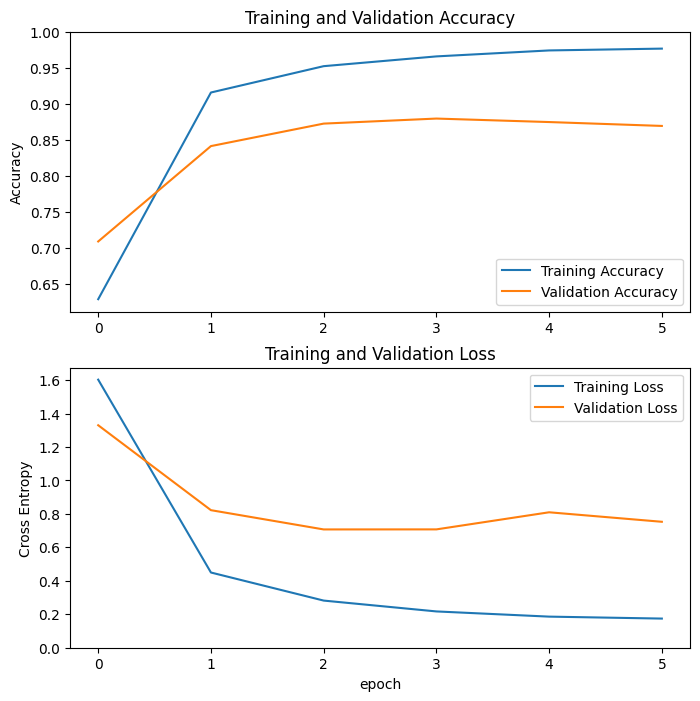

In [73]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a new figure
plt.figure(figsize=(8, 8))

# Subplot for accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Subplot for loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

# Show the figure
plt.show()

1/1 [==============================] - 1s 1s/step
Predicted class for ./dataset/test/Button _ v2.0 - 17.png: Buttons
1/1 [==============================] - 0s 331ms/step
Predicted class for ./dataset/test/Snackbar _ v1.3 - 21.png: Snackbar


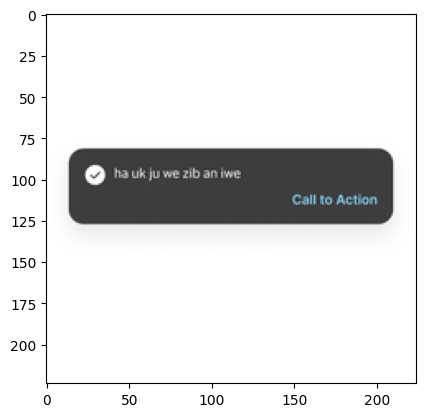

In [74]:
# Define the test images directory
test_images_dir = './dataset/test/'

# Get the list of all the test images
test_images = glob.glob(test_images_dir + '*.png')

# Loop through each test image
for test_image in test_images:
    # Open the image, resize it to the target size, and convert it to RGB
    img = Image.open(test_image).resize((IMG_SIZE, IMG_SIZE)).convert('RGB')

    # Convert the image to numpy array and normalize it
    img_array = np.array(img) / 255.

    # Add an extra dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)

    # Get the class name
    class_names = list(train_data.class_indices.keys())
    predicted_class_name = class_names[predicted_class]

    # Print the image and result
    plt.imshow(img)
    print(f"Predicted class for {test_image}: {predicted_class_name}")

In [75]:
# Save the model in TensorFlow SavedModel format
saved_model_dir = root_path + "saved_model/"  # Set your SavedModel directory path here
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: ./dataset/saved_model/assets


INFO:tensorflow:Assets written to: ./dataset/saved_model/assets


In [76]:
# Convert the SavedModel to TensorFlow.js format
!tensorflowjs_converter  --input_format=tf_saved_model --output_node_names="MobilenetV3/Predictions/Reshape_1" --control_flow_v2=True {saved_model_dir} {root_path + "tfjs_model/"}


In [77]:
# Get the current timestamp
now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

# Define the metadata
metadata = {
    "tfjsVersion": tfjs.__version__,
    "timeStamp": timestamp,  # Current timestamp
    "modelName": "Figma autoname plugin V1",  # Replace with your model name
    "labels": list(train_data.class_indices.keys()),  # Replace with your class labels
    "imageSize": IMG_SIZE
}

# Save the metadata to a JSON file
with open(root_path + "tfjs_model/" + 'metadata.json', 'w') as f:
    json.dump(metadata, f)